In [1]:
# handle image
import cv2
from matplotlib import pyplot as plt

# utils
import os
import random
import imutils
import numpy as np
import pandas as pd

# machine learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow import cast

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configurações

In [3]:
CURRENT_MODEL_VERSION = 1

TYPE_LOSS = "contrastive"

MODEL_LABEL = "dense" 

IMG_SHAPE = (150, 150, 3)
EMBEDDING_DIM = 1024

RESIZED_IMG_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1])

COLAB_PATH = "drive/MyDrive/"

DATASET_PATH = COLAB_PATH +'datasets/cropped_eyes.csv'

TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1

BATCH_SIZE = 64
EPOCHS = 120

BASE_OUTPUT = COLAB_PATH + "output"
MODEL_EXTENSION = ".hdf5"

FOLDER = os.path.sep.join([BASE_OUTPUT , MODEL_LABEL])
FOLDER = os.path.sep.join([FOLDER , TYPE_LOSS])
FOLDER = os.path.sep.join([FOLDER,"v{}".format(CURRENT_MODEL_VERSION)])

ACC_PATH = os.path.sep.join([FOLDER,"acc_test.txt"])
MODEL_INFO_PATH = os.path.sep.join([FOLDER,"model_info.txt"])
CHECKPOINTS_PATH = os.path.sep.join([FOLDER,"checkpoints"])


MODEL_PATH = os.path.sep.join([FOLDER, "siamese_model_{}".format(CURRENT_MODEL_VERSION)])
PLOT_PATH = os.path.sep.join([FOLDER, "plot-{}.png".format(CURRENT_MODEL_VERSION)])
PLOT_FEATURE_ARCHTECTURE_PATH = os.path.sep.join([FOLDER, "feature_extractor_arch-{}.png".format(CURRENT_MODEL_VERSION)])
PLOT_MODEL_ARCHTECTURE_PATH = os.path.sep.join([FOLDER, "model_arch-{}.png".format(CURRENT_MODEL_VERSION)])

SCORES = ['accuracy']


In [4]:
if not os.path.isdir(FOLDER):
  os.mkdir(FOLDER)
if not os.path.isdir(CHECKPOINTS_PATH):
  os.mkdir(CHECKPOINTS_PATH)

### Funções preprocessamento

In [5]:
def preprocess_image(filename):
  image = cv2.imread(filename)
  image = cv2.resize(image, RESIZED_IMG_SHAPE, interpolation = cv2.INTER_AREA)
  if IMG_SHAPE[2] == 1:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #image = tf.image.resize(image, target_shape)
  return image

In [6]:
def preprocess_triplets(images, labels):

  unique_labels = np.unique(labels)
  num_classes = len(unique_labels)
  idx = { "{}".format(i) :np.where(labels == i)[0] for i in unique_labels }

  pair_images = []
  pair_labels = []

  for idxA in range(len(images)):
    currentImage = preprocess_image(images[idxA])
    label = labels[idxA]


    idxB = np.random.choice(idx[label])
    posImage = preprocess_image(images[idxB])

    pair_images.append([currentImage, posImage])
    pair_labels.append([1])

    negIdx = np.where(labels != label)[0]
    negImage = preprocess_image(images[np.random.choice(negIdx)])

    pair_images.append([currentImage, negImage])
    pair_labels.append([0])
  
  return (np.array(pair_images), np.array(pair_labels))

### Funções NN

In [7]:
def build_siamese_model(inputShape, embeddingDim=EMBEDDING_DIM):
  inputs = Input(inputShape)

  x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters=64, kernel_size=(2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)


  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  model = Model(inputs, outputs)
  
  return model

In [8]:
def build_network():
  imgA = Input(shape=IMG_SHAPE)
  imgB = Input(shape=IMG_SHAPE)
  featureExtractor = build_siamese_model(IMG_SHAPE)
  featsA = featureExtractor(imgA)
  featsB = featureExtractor(imgB)

  distance = Lambda(euclidean_distance)([featsA, featsB])

  x = Dense(64, activation="relu")(distance)
  x = Dropout(0.3)(x)
  x = Dense(32, activation="tanh")(x)
  outputs = Dense(1, activation="sigmoid")(x)

  model = Model(inputs=[imgA, imgB], outputs=outputs)
  return model

In [9]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
    keepdims=True)
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [10]:
def contrastive_loss(y, preds, margin=1):
	y = cast(y, preds.dtype)

	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	return loss

In [11]:
def plot_training(H, plotPath):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Treinamento Loss e Accuracy")
	plt.xlabel("Épocas")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Criação do modelo

In [12]:
dataset = pd.read_csv(DATASET_PATH, index_col="Unnamed: 0")

In [13]:
#dataset = dataset[:][:100]

In [14]:
(pair_images, pair_labels) = preprocess_triplets(dataset['image_path'],dataset['class'])

In [15]:
X_train, X_rem, y_train, y_rem = train_test_split(pair_images, pair_labels, test_size=TEST_SIZE + VALIDATION_SIZE)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=TEST_SIZE)

In [16]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2720, 2, 150, 150, 3)
(2720, 1)
(932, 2, 150, 150, 3)
(932, 1)
(234, 2, 150, 150, 3)
(234, 1)


(None, None)

In [17]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


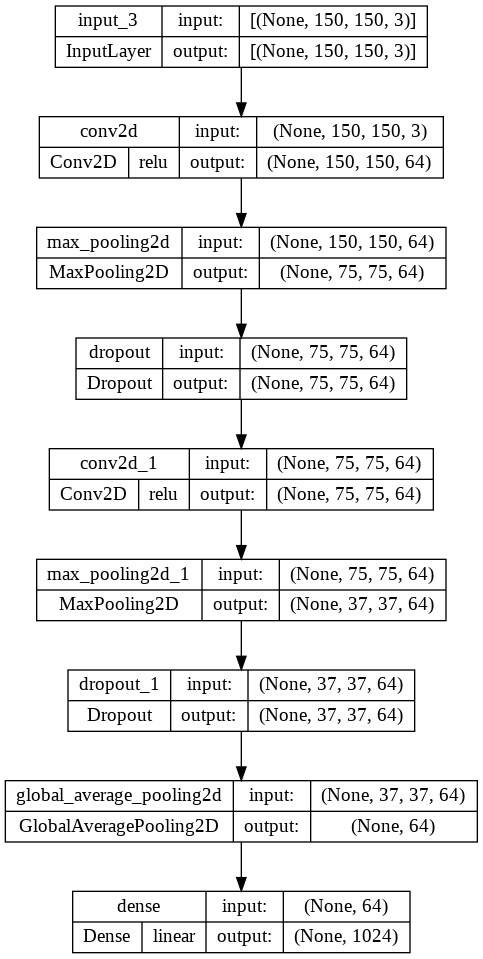

In [18]:
plot_model(featureExtractor,to_file=PLOT_FEATURE_ARCHTECTURE_PATH,show_shapes=True,show_layer_activations=True)

In [19]:
model = build_network()

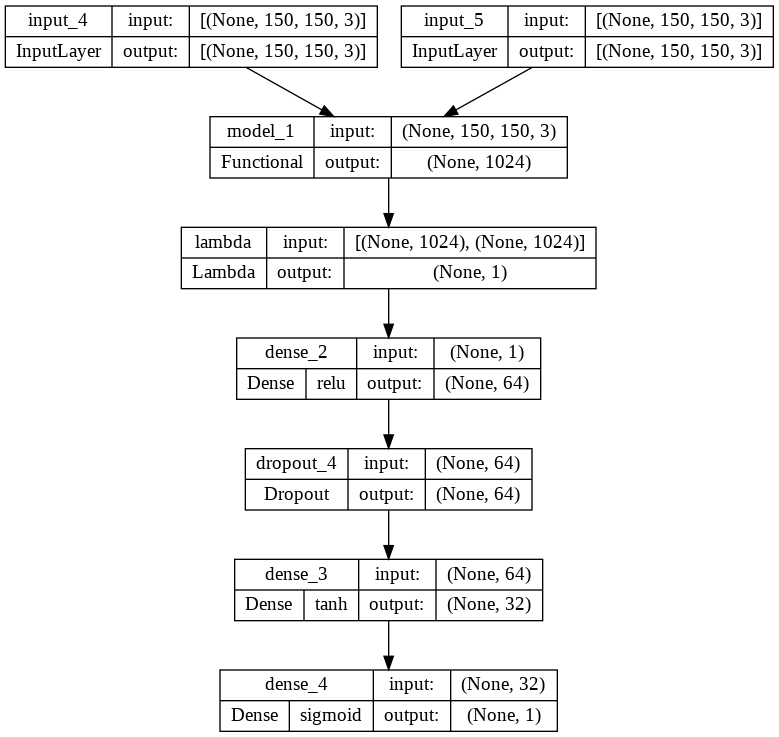

In [20]:
plot_model(model,to_file=PLOT_MODEL_ARCHTECTURE_PATH,show_shapes=True,show_layer_activations=True)

In [21]:
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam",
	metrics=SCORES)

[INFO] compiling model...


In [22]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINTS_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [23]:
#model_recovered = load_model(CHECKPOINTS_PATH)

In [25]:
history = model.fit(
                    [X_train[:, 0], X_train[:, 1]], y_train[:],
                    validation_data=([X_valid[:, 0], X_valid[:, 1]], y_valid[:]),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint_callback])

Epoch 1/120
43/43 [==============================] - 246s 6s/step - loss: 0.1152 - accuracy: 0.1588 - val_loss: 0.1568 - val_accuracy: 0.2178
Epoch 2/120
43/43 [==============================] - 238s 6s/step - loss: 0.1124 - accuracy: 0.1515 - val_loss: 0.1633 - val_accuracy: 0.2264
Epoch 3/120
43/43 [==============================] - 243s 6s/step - loss: 0.1165 - accuracy: 0.1614 - val_loss: 0.1559 - val_accuracy: 0.2221
Epoch 4/120
43/43 [==============================] - 242s 6s/step - loss: 0.1161 - accuracy: 0.1596 - val_loss: 0.1461 - val_accuracy: 0.2135
Epoch 5/120
43/43 [==============================] - 247s 6s/step - loss: 0.1121 - accuracy: 0.1471 - val_loss: 0.1544 - val_accuracy: 0.2221
Epoch 6/120
43/43 [==============================] - 247s 6s/step - loss: 0.1175 - accuracy: 0.1621 - val_loss: 0.1659 - val_accuracy: 0.2307
Epoch 7/120
43/43 [==============================] - 242s 6s/step - loss: 0.1128 - accuracy: 0.1588 - val_loss: 0.1477 - val_accuracy: 0.2114
Epoch 

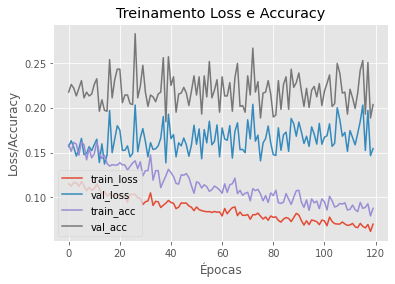

In [26]:
plot_training(history,PLOT_PATH)

### Salvar modelo

In [27]:
custom_objects = {"custom_activation": contrastive_loss}

In [28]:
config = model.get_config()

with utils.custom_object_scope(custom_objects):
    new_model = Model.from_config(config)
    new_model.save(MODEL_PATH)

In [ ]:
new_model.save(MODEL_PATH)

### Recuperar modelo salvo

In [29]:
model_recovered = load_model(MODEL_PATH)

### Aplicar modelo aos dados de teste

In [30]:
y_pred = model_recovered.predict([X_test[:, 0], X_test[:, 1]])

8/8 [==============================] - 8s 1s/step


In [31]:
mapper_class = lambda value: 1 if value > 0.5 else 0

In [32]:
y_mapped = [ mapper_class(value) for value in  y_pred]
y_mapped = np.asarray(y_mapped).reshape(-1,1)

In [33]:
evaluation = abs(y_mapped - y_test)

In [34]:
acc = (evaluation.shape[0] - sum(evaluation))/evaluation.shape[0]

In [35]:
with open(ACC_PATH, 'w') as f:
    f.write("acc: {}\n".format(acc))
    f.write("batch size: {}\n".format(BATCH_SIZE))
    f.write("epochs: {}\n".format(EPOCHS))

In [36]:
with open(MODEL_INFO_PATH, 'w') as f:
    model_recovered.summary(print_fn=lambda x: f.write(x + '\n'))